# Pair Traing Signal Test 

In [29]:
%load_ext autoreload
%autoreload 2
from data_filter import *
from config import *
from trading_strategy import *
from result_analysis import *
from itertools import product
import quandl
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools as ts

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
myAPIkey = 'VPTMgg7k44QB9_2PCKWD'
quandl.ApiConfig.api_key = myAPIkey

## Section 1. Choose Equities 

In this section, we will begin by identifying groups of highly correlated stocks within each industry. The data is sourced from Quandl, covering the period from 2015 to 2016. Next, we will select two stocks from each group to perform various exploratory data analyses (EDA) and statistical tests. 

In [8]:
test_start = '2015-01-01'
test_end = '2016-01-01'

In [9]:
df_MT = quandl.get_table('ZACKS/MT') 
list_filter, industry_list = industry_filter(df_MT)

Filter inactive tickers. Remaining tickers: 3674
Filter based on asset type. Remaining tickers: 1251


In [10]:
industry_dfs = get_adj_close_data(list_filter, industry_list, test_start, test_end)

In [25]:
# Utilize this part to choose two highly correlated stocks 
for industry, df in industry_dfs.items():
    #print(f'Display the correlation matrix of industy {industry}')
    correlation_matrix = df.corr()
    high_correlation = correlation_matrix.where((correlation_matrix >= 0.7) & (correlation_matrix < 1), other=float('nan'))    
    high_correlation = high_correlation.dropna(how='all').dropna(axis=1, how='all')
    #display(high_correlation)

Two stocks we have chosen for testing the trading strategy is WMT and ZUMZ. 

**WMT**: global retail giant with a diverse range of products, including groceries, electronics, and apparel, operating through hypermarkets and discount stores

**ZUMZ**: specialty retailer focused on action sports lifestyle, offering apparel, footwear, and accessories for skateboarding and snowboarding enthusiasts.

Then we will download data and conduct a basic analysis. From that, we can tell that WMT is more liquid than ZUMZ, though the price of ZUMZ is higher. 

In [26]:
df = download_data(['WMT','ZUMZ'],test_start,test_end)

In [29]:
df.head()

adj_close             volume          
ticker            WMT   ZUMZ         WMT      ZUMZ
date                                              
2015-01-02  23.496049  38.21   4501803.0  180321.0
2015-01-05  23.427667  38.94   6978986.0  241980.0
2015-01-06  23.608196  38.46   8202585.0  232571.0
2015-01-07  24.234575  40.28   8498008.0  315208.0
2015-01-08  24.746072  41.40  12703627.0  632950.0

In [48]:
cointegration_test(df['adj_close']['WMT'],df['adj_close']['ZUMZ'], significance_level=0.05)


{'Test Statistic': -3.457827509357472,
 'P-Value': 0.03632151652396405,
 'Critical Values': array([-3.94060523, -3.36058133, -3.06139039]),
 'Conclusion': 'The stocks are cointegrated'}

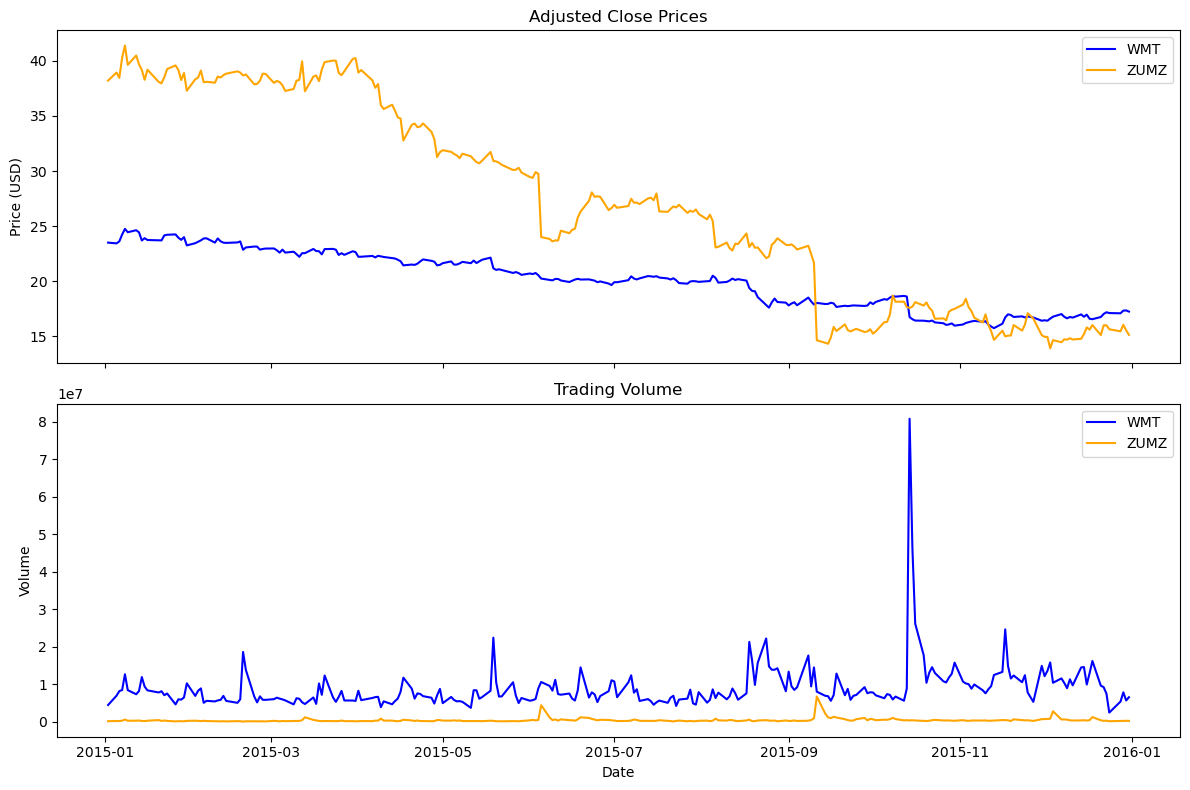

In [50]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax[0].plot(df.index, df['adj_close', 'WMT'], label='WMT', color='blue')
ax[0].plot(df.index, df['adj_close', 'ZUMZ'], label='ZUMZ', color='orange')
ax[0].set_title("Adjusted Close Prices")
ax[0].set_ylabel("Price (USD)")
ax[0].legend()

ax[1].plot(df.index, df['volume', 'WMT'], label='WMT', color='blue')
ax[1].plot(df.index, df['volume', 'ZUMZ'], label='ZUMZ', color='orange')
ax[1].set_title("Trading Volume")
ax[1].set_ylabel("Volume")
ax[1].legend()

plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Section 2. Pair Trading

1. Define arbitrary spread band j ~ g (j < g);
2. If the absolute value ETF pair price difference > upper bond g, start / maintain a short position of the ETF with higher current price;
3. On the contrary, if price difference < lower bound f, close any open position;
4. Stop loss if current open position loss > s * gross traded cash (i.e. sum of the absolute value of traded dollar amount when entering into a position)

We then calculate the position size $N_t$ based on rolling median volume of less liquid.
- $N_t$ = Median[{$V_{t-16}, V_{t-15}, \dots, V_{t-1}$}] 
- Number of shares = nearest integer of $N_t/100$

where V is the daily dollar volume.

In [10]:
df_trade = download_data([STOCK_HIGH,STOCK_LOW],START_DATE,END_DATE)

In [22]:
Nt = (df_trade[("adj_close", STOCK_LOW)] * df_trade[("volume", STOCK_LOW)]).rolling(15).median().shift(1)

# We define initial capital as max(N_t) 
K = Nt.max()
dollar_size = Nt / 100      # This will be dollar amount for X and Y when enter into position

### 2.1. Spread Calculation
It's more reasonable to assume the return of two similar assets should be close to each other, i.e. the return difference are mean reversed.

Therefore, we define M-day spread as:

$S_t^{(M)} = (\frac{P_{High Liquidity, t}}{P_{High Liquidity, t - M}} - 1) - (\frac{P_{Low Liquidity, t}}{P_{Low Liquidity, t - M}} - 1)$

where P represents the adjusted close price for the date.

We select M = 1, 5, 10, 20, 63, 126, 252 and investigate the spreads' basic statistics and distribution.

In [23]:
df_price = df_trade["adj_close"][[STOCK_HIGH, STOCK_LOW]]
df_spread = pd.DataFrame({
    m: calc_spread(df_price, m)
    for m in [1, 5, 10, 20, 63, 126, 252]
})

pd.concat([df_spread.describe().T, 
           df_spread.skew().rename("skew"), 
           df_spread.kurt().rename("kurt")], axis=1)

,count,mean,std,min,25%,50%,75%,max,skew,kurt
1,1509.0,-0.000038,0.033423,-0.188311,-0.018246,0.000102,0.019704,0.182676,-0.504355,3.827844
5,1509.0,0.000022,0.072605,-0.480338,-0.038403,0.004686,0.044463,0.301434,-0.673958,3.297261
10,1509.0,0.000219,0.098301,-0.486624,-0.056794,0.005622,0.063317,0.393253,-0.463687,1.679113
20,1509.0,0.000010,0.140164,-0.536284,-0.083575,0.007306,0.087556,0.510076,-0.300637,0.791914
63,1509.0,0.009677,0.223187,-0.924824,-0.145332,0.018911,0.163924,0.588568,-0.123466,-0.022785
126,1509.0,0.009458,0.315472,-1.013181,-0.236199,0.066327,0.276194,0.570952,-0.545414,-0.460969
252,1508.0,0.029934,0.464482,-1.821801,-0.236736,0.129806,0.397808,0.821838,-0.944549,0.550158


Text(0.5, 0, 'Spread')

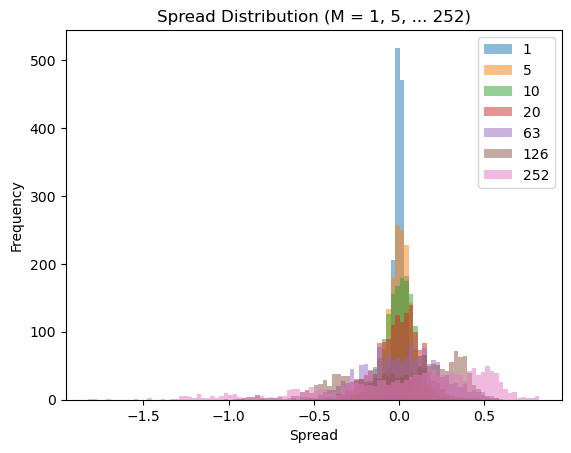

In [24]:
ax = df_spread.plot.hist(bins=100, alpha=0.5, title="Spread Distribution (M = 1, 5, ... 252)")
ax.set_xlabel("Spread")

1      0.000000e+00
5      9.699640e-12
10     2.651679e-09
20     5.720076e-07
63     3.904377e-04
126    1.088255e-02
252    1.265154e-01
dtype: float64


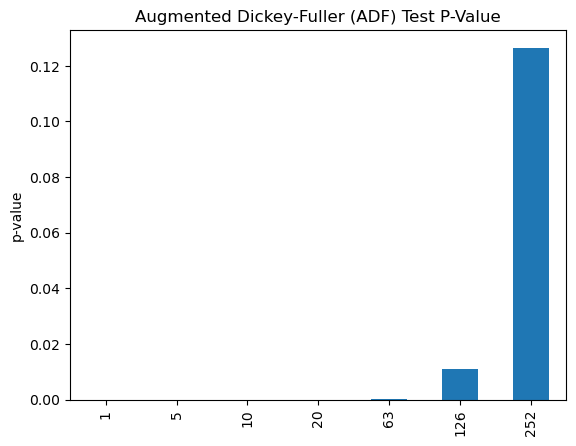

In [25]:
df_spread_adf = df_spread.apply(lambda x: ts.adfuller(x.dropna())[1])
print(df_spread_adf)
ax = df_spread_adf.plot(
    kind="bar",
    title="Augmented Dickey-Fuller (ADF) Test P-Value",
    ylabel="p-value"
)

### 2.2. Example Trade

Since stop loss evaluation requires iterate through daily data sequentially, i.e. not vectorizable, we separate vectorizable functions before iteration process. 

The calc_position_by_spread() below makes independent judgement of spread data on each date and give position:
- 0 if all position should be closed on the date
- np.nan if no position change should happen on the date (e.g. spread within band)
- pd.Series with non-0 value if we should keep an open position on the date

In [26]:
# Example unadjusted position based on M=5 and j/g selected by absolute spread quantile
spread = calc_spread(df_price, m=5)
position = calc_position_by_spread(df_price, spread, 
                                   j=spread.abs().quantile(0.25), 
                                   g=spread.abs().quantile(0.75),
                                   dollar_size=dollar_size)
position.head()

,WMT,ZUMZ
date,,
2018-01-02,NaN,NaN
2018-01-03,NaN,NaN
2018-01-04,1699.0,-2187.0
2018-01-05,NaN,NaN
2018-01-08,2478.0,-3249.0


In [27]:
# Example trade dataframe with position example above 
trade = CalcTrade(df_price=df_price, position=position, 
                  s=0.01, cost=1e-5, init_cap=K).iter_dates()
trade.head()

price        raw_position         position        \
                  WMT   ZUMZ          WMT    ZUMZ      WMT  ZUMZ   
2018-01-02  29.254564  20.00          NaN     NaN        0     0   
2018-01-03  29.509752  20.50          NaN     NaN        0     0   
2018-01-04  29.536457  22.95       1699.0 -2187.0     1699 -2187   
2018-01-05  29.711528  22.55          NaN     NaN     1699 -2187   
2018-01-08  30.150687  23.00       2478.0 -3249.0     1699 -2187   

           position_dollar           trade        trade_dollar            \
                       WMT      ZUMZ   WMT  ZUMZ           WMT      ZUMZ   
2018-01-02        0.000000      0.00     0     0      0.000000      0.00   
2018-01-03        0.000000      0.00     0     0      0.000000      0.00   
2018-01-04    50182.440761 -50191.65  1699 -2187 -50182.440761  50191.65   
2018-01-05    50479.885407 -49316.85     0     0      0.000000      0.00   
2018-01-08    51226.017739 -50301.00     0     0      0.000000      0.00   

                   summary                                           \
           net_traded_cash gross_traded_cash trading_cost  open_pnl   
2018-01-02        0.000000          0.000000     0.000000       NaN   
2018-01-03        0.000000          0.000000     0.000000       NaN   
2018-01-04       -9.209239     100374.090761     1.003741  0.000000   
2018-01-05       -9.209239     100374.090761     0.000000  0.011679   
2018-01-08       -9.209239     100374.090761     0.000000  0.009307   

                 balance                                           
                    cash     position         total     total_ret  
2018-01-02  2.403719e+07     0.000000  2.403719e+07  0.000000e+00  
2018-01-03  2.403719e+07     0.000000  2.403719e+07  0.000000e+00  
2018-01-04  2.403720e+07    -9.209239  2.403719e+07 -4.175782e-08  
2018-01-05  2.403720e+07  1163.035407  2.403837e+07  4.872619e-05  
2018-01-08  2.403720e+07   925.017739  2.403813e+07  3.882413e-05

<Axes: title={'center': 'Example Strategy Returns'}>

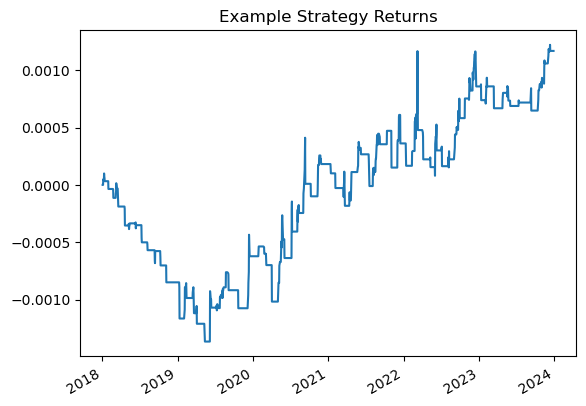

In [28]:
trade[("balance", "total_ret")].plot(title="Example Strategy Returns")

### 2.3 Optimized Trade 

There are 5 parameters influencing the trading decision of our strategy:
1. j: lower bound of spread band
2. g: upper bound of spread band
3. s: stop loss level
4. $\zeta$ / cost: trading cost multiplier
5. M: M-day cumulative return to calculate spread

We first try the most straight-forward way to find better parameters among given options. We tried:
1. j/g: [(40%, 60%), (25%, 75%), (10%, 90%)] quantile of the absolute value of spreads
2. s: [0.1%, 1%, 5%]
3. M: [5, 63, 252]


In [31]:
ff = download_ff_data()
ff.tail()

,Mkt-RF,SMB,HML,RF
0,,,,
2023-12-22,0.20,0.64,0.10,0.021
2023-12-26,0.48,0.71,0.43,0.021
2023-12-27,0.16,0.14,0.10,0.021
2023-12-28,-0.01,-0.36,0.02,0.021
2023-12-29,-0.43,-1.14,-0.36,0.021


In [32]:
print("For comparison, we calculate the 0 risk-free rate market sharpe ratio as: {:.4f} ({} ~ {})".format(
    sharpe_ratio(ff["Mkt-RF"] + ff["RF"], ann_factor=1), ff.index.min(), ff.index.max()))

For comparison, we calculate the 0 risk-free rate market sharpe ratio as: 0.0451 (2017-01-03 00:00:00 ~ 2023-12-29 00:00:00)


In [33]:
dict_ret = {}
dict_stat = {}
for (j, g), s, m, cost in product(
    [(0.4, 0.6), (0.25, 0.75), (0.1, 0.9)],
    [0.001, 0.01, 0.05],
    [5, 63, 252],
    [0, 1e-5]
):
    dict_ret[(j, g, s, m, cost)] = exec_trade(m=m, j=j, g=g, s=s, cost=cost, dollar_size=dollar_size, K=K, df_price=df_price)
    dict_stat[(j, g, s, m, cost)] = eval_return(dict_ret[(j, g, s, m, cost)],
                                                df_ff=ff)

In [36]:
comp_stat = pd.DataFrame(dict_stat).T
comp_stat.index.names = ["j", "g", "s", "m", "cost"]

comp_stat[["return", "sharpe", "sortino", "alpha"]].apply(pd.to_numeric, axis=1).describe()

,return,sharpe,sortino,alpha
count,5.400000e+01,54.000000,54.000000,54.000000
mean,1.491944e-09,0.143729,0.143110,0.000493
std,2.781607e-09,0.407681,0.283853,0.000689
min,-2.790850e-09,-0.665733,-0.320498,-0.000528
25%,-9.914199e-10,-0.171296,-0.105530,0.000026
50%,1.470633e-09,0.240219,0.149519,0.000300
75%,4.155984e-09,0.453223,0.389177,0.001107
max,7.338522e-09,0.736630,0.765055,0.002203


As shown in the descriptive statistics above, although return remain small even for the best case due to very large initial capital we select, this strategy on average earns a position return / alpha in most parameters. 

Therefore, our evaluation below focus on return comparison. 

In [37]:
pd.concat([comp_stat.sort_values(["return"], ascending=False).head(),
           comp_stat.sort_values(["return"], ascending=False).tail()])

return    sharpe   sortino     alpha  \
j    g    s     m   cost                                           
0.40 0.60 0.050 5   0.00000    0.0   0.73663  0.711385  0.002203   
                    0.00001    0.0  0.733404  0.765055  0.002197   
0.10 0.90 0.050 252 0.00000    0.0  0.695631  0.636865  0.001366   
                    0.00001    0.0  0.695536  0.635943  0.001366   
          0.010 252 0.00000    0.0   0.61368  0.476784  0.001147   
0.40 0.60 0.010 63  0.00001   -0.0 -0.342361  -0.20565 -0.000417   
0.25 0.75 0.001 63  0.00000   -0.0 -0.664135 -0.300461  -0.00046   
                    0.00001   -0.0 -0.665733 -0.310336 -0.000461   
          0.010 63  0.00000   -0.0 -0.596951 -0.316201 -0.000527   
                    0.00001   -0.0 -0.598296 -0.320498 -0.000528   

                                                                          beta  \
j    g    s     m   cost                                                         
0.40 0.60 0.050 5   0.00000  [0.0008278111917362138, 0.0019581500769890892,...   
                    0.00001  [0.0008279832209577578, 0.0019584070386530427,...   
0.10 0.90 0.050 252 0.00000  [0.0009641934895929216, -0.0012070042954203139...   
                    0.00001  [0.00096418567992712, -0.001206920551592165, 0...   
          0.010 252 0.00000  [0.0009836138177246128, -0.0007184782927685219...   
0.40 0.60 0.010 63  0.00001  [0.00012274472393841167, -0.000212814518312556...   
0.25 0.75 0.001 63  0.00000  [-0.00039185035086672924, -0.00045124341798586...   
                    0.00001  [-0.00039186975325735605, -0.00045099133703219...   
          0.010 63  0.00000  [-6.712734437107862e-05, -0.000664175299691192...   
                    0.00001  [-6.710134481261399e-05, -0.000664071297061126...   

                            downside_beta  
j    g    s     m   cost                   
0.40 0.60 0.050 5   0.00000      0.050192  
                    0.00001      0.050201  
0.10 0.90 0.050 252 0.00000      0.040047  
                    0.00001      0.040044  
          0.010 252 0.00000      0.036092  
0.40 0.60 0.010 63  0.00001      0.064934  
0.25 0.75 0.001 63  0.00000     -0.007336  
                    0.00001     -0.007304  
          0.010 63  0.00000      0.072689  
                    0.00001       0.07272

Text(0, 0.5, 'Return')

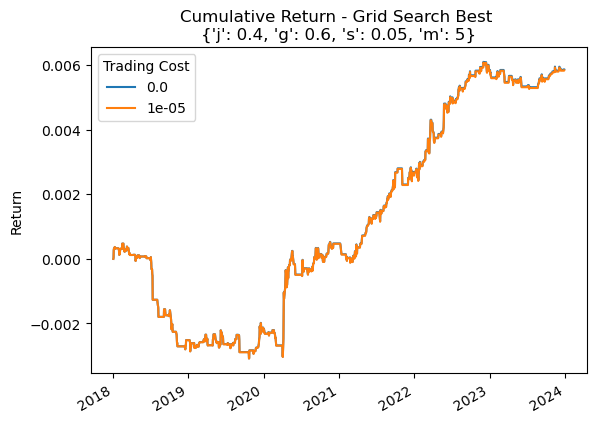

In [48]:
best_gs_param = comp_stat.sort_values(["return"], ascending=False).iloc[0].name
best_gs_param_dict = dict(zip(comp_stat.index.names[:-1], best_gs_param[:-1]))
best_gs_ret = pd.DataFrame({
    c: dict_ret[(*best_gs_param[:-1], c)] for c in [0, 1e-5]
})
best_gs_ret.columns.name = "Trading Cost"
ax = best_gs_ret.plot(title=f"Cumulative Return - Grid Search Best \n{best_gs_param_dict}")
ax.set_ylabel("Return")

## Section 3. Performance Report

In [94]:
best_gs_param_dict

{'j': 0.4, 'g': 0.6, 's': 0.05, 'm': 5}

In [50]:
best_gs_ret = best_gs_ret * 100

In [51]:
best_gs_ret.tail(1)

Trading Cost,0.00000,0.00001
2023-12-29,0.586202,0.583578


#### 1 year 

<Axes: >

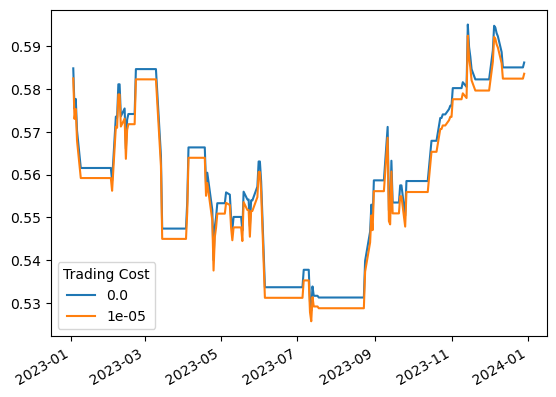

In [60]:
best_gs_ret.loc['2023-01-01':].plot()


#### 3 year 

<Axes: >

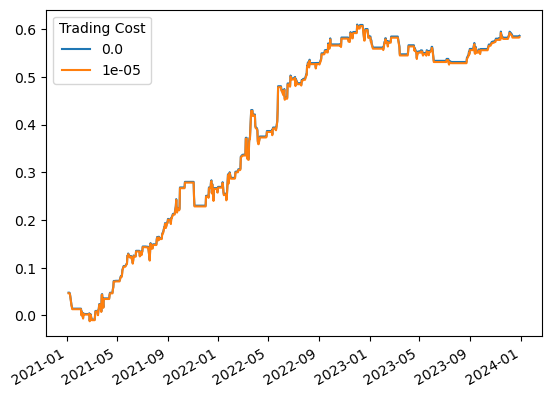

In [61]:
best_gs_ret.loc['2021-01-01':].plot()

#### 5 year 

<Axes: >

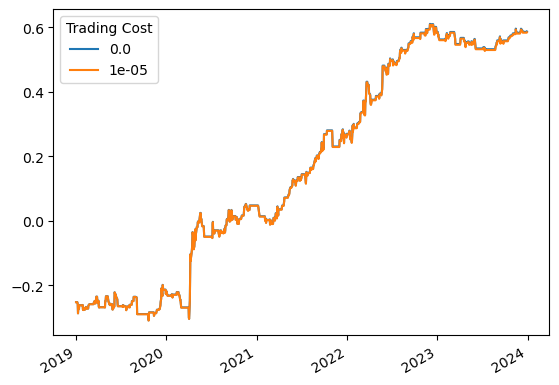

In [62]:
best_gs_ret.loc['2019-01-01':].plot()


### Performance Metrics 

In [95]:
spread = calc_spread(df_price, m=5)
position = calc_position_by_spread(df_price, spread, 
                                   j=spread.abs().quantile(0.4), 
                                   g=spread.abs().quantile(0.6),
                                   dollar_size=dollar_size)

In [103]:
trade = CalcTrade(df_price=df_price, position=position, 
                  s=0.05, cost=1e-5, init_cap=K).iter_dates()

In [104]:
daily_return = trade['balance','total'].pct_change().to_frame().dropna()

In [109]:
daily_return.columns = ['daily_return']

Here, sharpe ratio is calcualed by ret/vol, no benchmark. 

In [128]:
calculate_annual_summary(daily_return,ff[['RF']])

,% Return,% Volatility,Sharpe Ratio,Max Drawdown (%)
Year,,,,
2018,-0.252%,0.116%,-8.36,-0.327%
2019,0.025%,0.113%,-7.28,-0.087%
2020,0.274%,0.186%,0.64,-0.086%
2021,0.221%,0.129%,1.72,-0.059%
2022,0.314%,0.153%,-1.64,-0.070%
2023,0.001%,0.068%,-28.22,-0.056%
Total,0.584%,0.133%,4.391,-0.056%
